In [1]:
import numpy as np
import torch
from torch import nn
import torchaudio
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
import timm
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, f1_score, classification_report, ConfusionMatrixDisplay

In [2]:
train_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
train_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
len(os.listdir(train_audio_files_path))

25380

In [3]:
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text
    
def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
        
    return filename2label

In [4]:
filename2label = getlabels(train_labels_path)

  0%|          | 0/25380 [00:00<?, ?it/s]

In [5]:
val_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
val_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
val_filename2label = getlabels(val_labels_path)

  0%|          | 0/24844 [00:00<?, ?it/s]

2580 22800


(array([ 2580.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22800.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

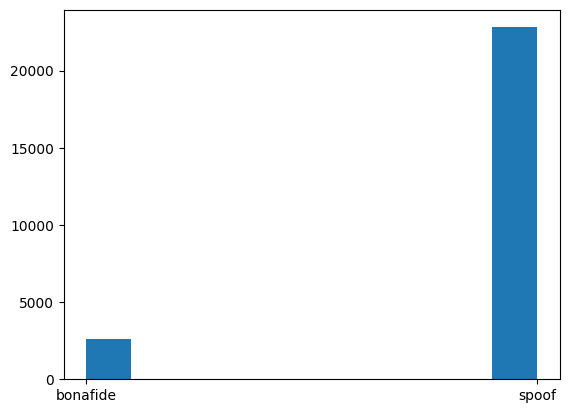

In [6]:
l = list(filename2label.values())
print(l.count('bonafide'), l.count('spoof'))
plt.hist(l)

In [7]:
class ASVSpoof(torch.utils.data.Dataset):
    def __init__(self, audio_dir_path, num_samples, filename2label, transforms):
        super().__init__()
        self.audio_dir_path = audio_dir_path
        self.num_samples = num_samples
        self.audio_file_names = self.get_audio_file_names(filename2label)
        self.labels, self.label2id, self.id2label = self.get_labels(filename2label)
        self.transforms = transforms
        
    def __getitem__(self, index):
        signal, sr = torchaudio.load(os.path.join(self.audio_dir_path, self.audio_file_names[index]))
#         print(signal.shape)
        signal = self.mix_down_if_necessary(signal)
        signal = self.cut_if_necessary(signal)
#         print(signal.shape)
        signal = self.right_pad_if_necessary(signal)
#         print(signal.shape)
        signal = self.transforms(signal)
#         print(signal.shape)
        label = (self.labels[index])
        return signal, label
    
    def __len__(self):
        return len(self.labels)
    
    def get_audio_file_names(self, filename2label):
        audio_file_names = list(filename2label.keys())
        audio_file_names = [name + '.flac' for name in audio_file_names] # adding extension
        return audio_file_names
    
    def get_labels(self, filename2label):
        labels = list(filename2label.values())
        id2label = {idx : label for idx, label in  enumerate(list(set(labels)))}
        label2id = {label : idx for idx, label in  enumerate(list(set(labels)))}
        labels = [label2id[label] for label in labels]
        return labels, label2id, id2label
    
    def mix_down_if_necessary(self, signal): #converting from stereo to mono
        if signal.shape[0] > 1: 
            signal = torch.mean(signal, dim = 0, keepdims = True)
        return signal
    
    def cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :num_samples]
        return signal
    
    def right_pad_if_necessary(self, signal):
        length = signal.shape[1]
        if self.num_samples > length:
            pad_last_dim = (0, num_samples - length)
            signal = torch.nn.functional.pad(signal, pad_last_dim)
        return signal

In [8]:
mel_spectogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = 16000,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)
num_samples = 6 * 16000 # IMPORTANT!!
train_dataset = ASVSpoof(train_audio_files_path, num_samples, filename2label, mel_spectogram)
val_dataset = ASVSpoof(val_audio_files_path, num_samples, val_filename2label, mel_spectogram)

In [9]:
train_dataset[0][0].shape

torch.Size([1, 64, 188])

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('resnet101', pretrained = True, in_chans = 1)
        for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:39]):
            param.requires_grad = False
            
        self.features = nn.Sequential(*list(self.model.children())[:-2])
        
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        x = self.features(inputs)
        x = self.custom_layers(x)
        return x
        

In [11]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
num_epochs = 8
criterion = nn.BCELoss()
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())

cuda


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = 512)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = 1024)

In [13]:
for epoch in range(num_epochs):
    train_loss = 0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (images, labels) in loop:
        loop.set_description(f'Epoch {epoch + 1} / {num_epochs} ')
#         forward pass
        model.train()
        images = images.to(device)
        labels = labels.to(device).reshape(-1, 1)
        labels = labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
#         print(labels.shape)
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        train_loss += loss.item()
#         backward pass
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(Training_loss = loss.item())
        
#   validation every epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
        for val_batch_idx, (val_images, val_labels) in val_loop:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).reshape(-1, 1)
            val_labels = val_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu
            val_outputs = model(val_images)
            curr_val_loss = criterion(val_outputs, val_labels)
            val_loss += curr_val_loss.item()
            val_loop.set_postfix(validation_loss = curr_val_loss.item())
    print(f'Epoch : {epoch + 1} Training loss : {train_loss / train_loader.batch_size} Validation loss : {val_loss / val_loader.batch_size}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 1 Training loss : 0.03272310641477816 Validation loss : 0.006387619097949937


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 2 Training loss : 0.017704906727885827 Validation loss : 0.005472417615237646


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 3 Training loss : 0.009568757406668738 Validation loss : 0.004809756719623692


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 4 Training loss : 0.004521069364272989 Validation loss : 0.005562779697356746


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 5 Training loss : 0.002328655908058863 Validation loss : 0.006240669565158896


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 6 Training loss : 0.0019849950231218827 Validation loss : 0.006350939991534688


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 7 Training loss : 0.0015050331958263996 Validation loss : 0.0054169480135897174


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch : 8 Training loss : 0.0012665539907175116 Validation loss : 0.006286962088779546


In [14]:
# Evaluating on val set
model.eval()
outputs = []
labels = []
with torch.no_grad():
    val_loop = tqdm(enumerate(val_loader), total = len(val_loader))
    for val_batch_idx, (val_images, val_labels) in val_loop:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device).reshape(-1, 1)
        val_labels = val_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu

        val_outputs = model(val_images)
        outputs.append(val_outputs.cpu().numpy())
        labels.append(val_labels.cpu().numpy())
        curr_val_loss = criterion(val_outputs, val_labels)
        val_loss += curr_val_loss.item()
        val_loop.set_postfix(validation_loss = curr_val_loss.item())

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
labels = np.concatenate(labels)
outputs = np.concatenate(outputs)
print(labels.shape, outputs.shape)

(24844, 1) (24844, 1)


In [16]:
score = roc_auc_score(labels, outputs)
score

0.9489395198130591

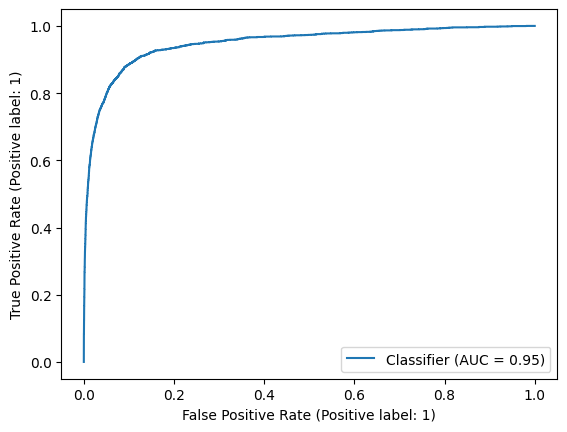

In [17]:
RocCurveDisplay.from_predictions(labels, outputs)

In [18]:
test_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac'
test_labels_path = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_filename2label = getlabels(test_labels_path)

  0%|          | 0/71237 [00:00<?, ?it/s]

In [19]:
test_dataset = ASVSpoof(test_audio_files_path, num_samples, test_filename2label, mel_spectogram)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = 1024)

In [20]:
# Evaluating on val set
model.eval()
outputs = []
labels = []
test_loss = 0.0
with torch.no_grad():
    test_loop = tqdm(enumerate(test_loader), total = len(test_loader))
    for test_batch_idx, (test_images, test_labels) in test_loop:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device).reshape(-1, 1)
        test_labels = test_labels.type(torch.cuda.FloatTensor) #use torch.FloatTensor if on cpu

        test_outputs = model(test_images)
        outputs.append(test_outputs.cpu().numpy())
        labels.append(test_labels.cpu().numpy())
        curr_test_loss = criterion(test_outputs, test_labels)
        test_loss += curr_test_loss.item()
        test_loop.set_postfix(test_loss = curr_test_loss.item())

  0%|          | 0/70 [00:00<?, ?it/s]

In [21]:
labels = np.concatenate(labels)
outputs = np.concatenate(outputs)
print(labels.shape, outputs.shape)

(71237, 1) (71237, 1)


In [22]:
score = roc_auc_score(labels, outputs)
score

0.9221938920312606

In [23]:
def convert_into_whole(outputs):
    new_output = []
    for o in outputs:
        if o > 0.5:
            new_output.append(1)
        else:
            new_output.append(0)
    return new_output

new_outputs = convert_into_whole(outputs)

In [24]:
print(classification_report(labels, new_outputs))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     63882
         1.0       0.52      0.68      0.59      7355

    accuracy                           0.90     71237
   macro avg       0.74      0.81      0.77     71237
weighted avg       0.92      0.90      0.91     71237



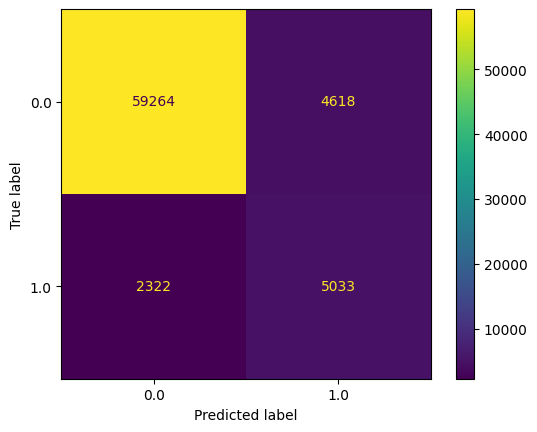

In [25]:
ConfusionMatrixDisplay.from_predictions(labels, new_outputs)

In [26]:
test_dataset.label2id

{'spoof': 0, 'bonafide': 1}

In [27]:
torch.save(model.state_dict(), 'resnet101.pt')

In [28]:
fpr, tpr, threshold = roc_curve(labels, new_outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold

1

In [29]:
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.07228953382799537